In [1]:
import os
os.environ['TP_CPP_MIN_MAX_LEVEL'] = '2'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_fscore_support

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-05-31 15:48:40.398250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748706520.610300      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748706520.672646      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
train_dir = '/kaggle/input/dat-lab1-dataset/seg_train/seg_train'
test_dir = '/kaggle/input/dat-lab1-dataset/seg_test/seg_test'
pred_dir = '/kaggle/input/dat-lab1-dataset/seg_pred/seg_pred'

buidings_dir = os.path.join(train_dir, 'buildings')
forest_dor = os.path.join(train_dir, 'forest')
glacier_dir = os.path.join(train_dir, 'glacier')
mountain_dir = os.path.join(train_dir, 'mountain')
sea_dir = os.path.join(train_dir, 'sea')
streat_dir = os.path.join(train_dir, 'street')


# Load Dataset

In [7]:
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_dataset_final = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_dataset_final = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Data Augmentation

In [8]:
FILL_MODE = 'nearest'

data_augmentation = keras.Sequential([
    keras.Input(shape = (150, 150, 3)),
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2, fill_mode = FILL_MODE),
    layers.RandomTranslation(0.2, 0.2, fill_mode = FILL_MODE),
    layers.RandomZoom(0.2, fill_mode = FILL_MODE)
])

I0000 00:00:1748706538.667746      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748706538.668423      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [9]:
def demo_augmentation(sample_image, datagen, num_aug):
    image_preview = []

    sample_image = sample_image / 255.0
    sample_image = np.expand_dims(sample_image, 0)

    image_preview.append(tf.keras.utils.array_to_img(sample_image[0]))

    # Generate augmented images
    aug_iter = datagen.flow(sample_image, batch_size=1)

    for i in range(num_aug):
        aug_image = next(aug_iter)[0]
        aug_image_pil = tf.keras.utils.array_to_img(aug_image)
        image_preview.append(aug_image_pil)

    fig, axes = plt.subplots(1, num_aug + 1, figsize=(12, 12))
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()
        ax.set_title('original' if index == 0 else f'augment {index}')

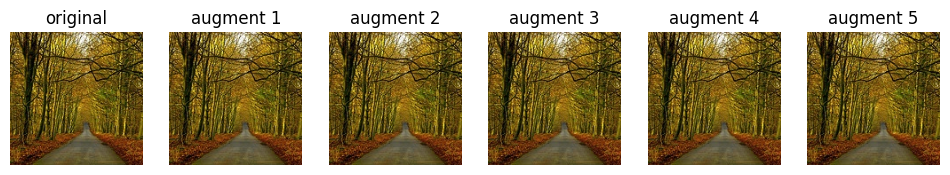

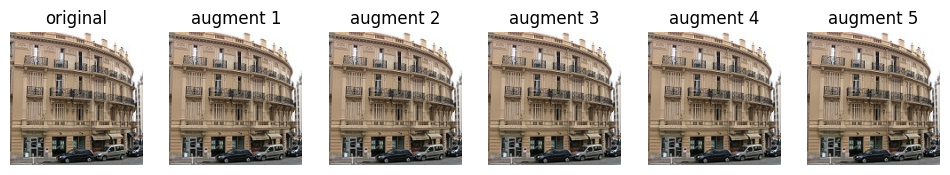

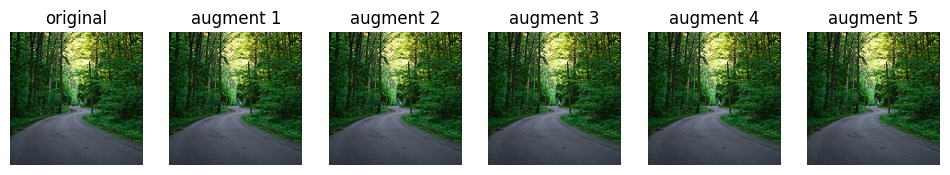

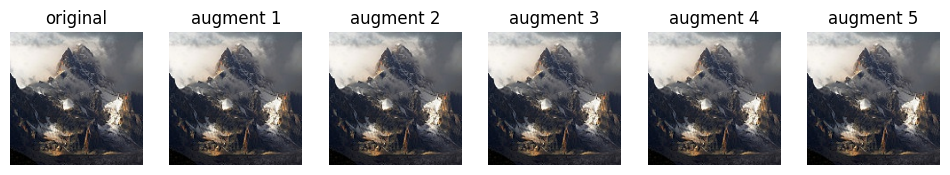

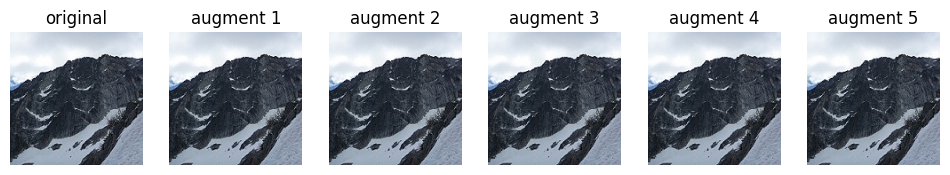

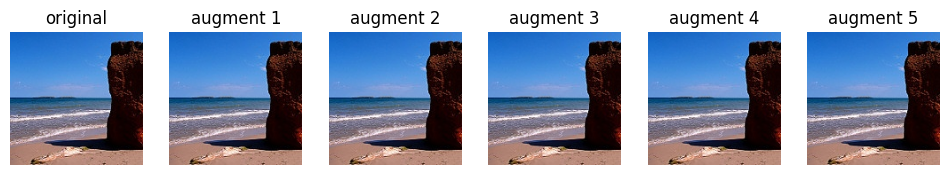

In [10]:
demo_augmentation(next(train_dataset_final)[0][0], train_datagen, num_aug=5)
demo_augmentation(next(train_dataset_final)[0][1], train_datagen, num_aug=5)
demo_augmentation(next(train_dataset_final)[0][2], train_datagen, num_aug=5)
demo_augmentation(next(train_dataset_final)[0][3], train_datagen, num_aug=5)
demo_augmentation(next(train_dataset_final)[0][4], train_datagen, num_aug=5)
demo_augmentation(next(train_dataset_final)[0][5], train_datagen, num_aug=5)

# Analyze and Visualize data distribution

In [11]:
def getDataQuantity(generator_iterator):
    labels = generator_iterator.classes
    class_names = list(generator_iterator.class_indices.keys())

    count = pd.Series(labels).value_counts().sort_index()
    count.index = class_names
    return count

In [12]:
train_quantity = getDataQuantity(train_dataset_final)
test_quantity = getDataQuantity(test_dataset_final)

In [13]:
freqs_df = train_quantity.to_frame().rename(columns = {'count' : 'train'})
freqs_df['test'] = test_quantity

In [14]:
freqs_df

,train,test
buildings,2191,437
forest,2271,474
glacier,2404,553
mountain,2512,525
sea,2274,510
street,2382,501


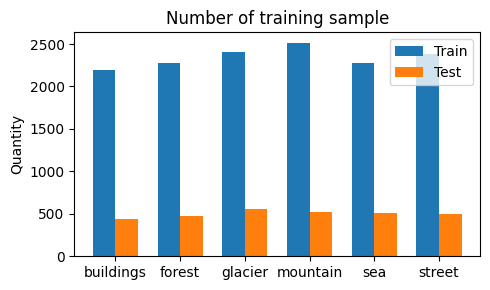

In [15]:
x = np.arange(freqs_df.shape[0])
width = 0.35

fig, ax = plt.subplots(figsize=(5, 3))

train_bar = ax.bar(x - width / 2, freqs_df['train'], width, label = 'Train')
test_bar = ax.bar(x + width / 2, freqs_df['test'], width, label = 'Test')

ax.set_ylabel('Quantity')
ax.set_title('Number of training sample')
ax.set_xticks(x)
ax.set_xticklabels(freqs_df.index)
ax.legend()

plt.tight_layout()
plt.show()

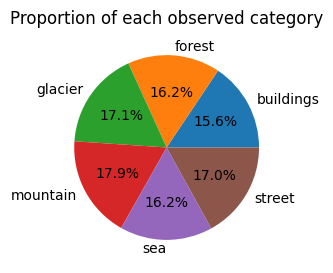

In [16]:
plt.figure(figsize = (5, 3))
plt.pie(freqs_df['train'], labels = freqs_df.index, autopct = '%1.1f%%')
plt.title('Proportion of each observed category')
plt.show()

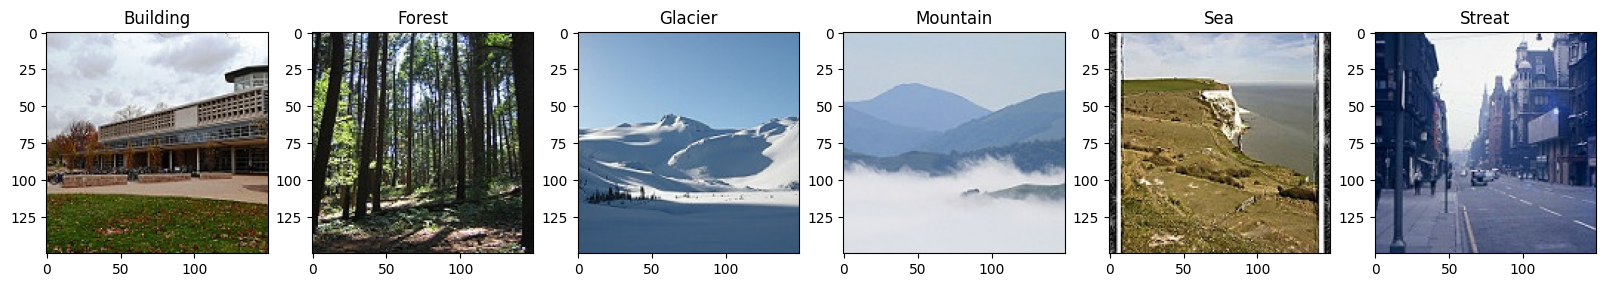

In [17]:
fig, axs = plt.subplots(1, 6, figsize=(20, 5))

axs[0].imshow(keras.utils.load_img(f"{os.path.join(buidings_dir, os.listdir(buidings_dir)[0])}"))
axs[0].set_title('Building')

axs[1].imshow(keras.utils.load_img(f"{os.path.join(forest_dor, os.listdir(forest_dor)[0])}"))
axs[1].set_title('Forest')

axs[2].imshow(keras.utils.load_img(f"{os.path.join(glacier_dir, os.listdir(glacier_dir)[0])}"))
axs[2].set_title('Glacier')

axs[3].imshow(keras.utils.load_img(f"{os.path.join(mountain_dir, os.listdir(mountain_dir)[0])}"))
axs[3].set_title('Mountain')

axs[4].imshow(keras.utils.load_img(f"{os.path.join(sea_dir, os.listdir(sea_dir)[0])}"))
axs[4].set_title('Sea')

axs[5].imshow(keras.utils.load_img(f"{os.path.join(streat_dir, os.listdir(streat_dir)[0])}"))
axs[5].set_title('Streat')

plt.show()

# Model

In [18]:
model = keras.models.Sequential([
    keras.Input(shape = (150, 150, 3)),
    data_augmentation,
    layers.Rescaling(1. / 255),
    layers.Conv2D(32, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation = 'relu'),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(6, activation = 'softmax')
])

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,585,478 (13.68 MB)

 Trainable params: 3,585,478 (13.68 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = keras.optimizers.Adam(0.001),
    metrics = ['accuracy']
)

In [21]:
history = model.fit(
      train_dataset_final,
      epochs = 20,
      validation_data = test_dataset_final,
      verbose=2)

Epoch 1/20


I0000 00:00:1748706549.624123     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


439/439 - 65s - 148ms/step - accuracy: 0.1751 - loss: 1.7916 - val_accuracy: 0.1750 - val_loss: 1.7904
Epoch 2/20
439/439 - 23s - 52ms/step - accuracy: 0.1769 - loss: 1.7910 - val_accuracy: 0.1750 - val_loss: 1.7903
Epoch 3/20
439/439 - 23s - 53ms/step - accuracy: 0.1790 - loss: 1.7910 - val_accuracy: 0.1750 - val_loss: 1.7903
Epoch 4/20
439/439 - 22s - 51ms/step - accuracy: 0.1790 - loss: 1.7910 - val_accuracy: 0.1750 - val_loss: 1.7901
Epoch 5/20
439/439 - 23s - 51ms/step - accuracy: 0.1790 - loss: 1.7910 - val_accuracy: 0.1750 - val_loss: 1.7902
Epoch 6/20
439/439 - 23s - 52ms/step - accuracy: 0.1790 - loss: 1.7910 - val_accuracy: 0.1750 - val_loss: 1.7903
Epoch 7/20
439/439 - 23s - 51ms/step - accuracy: 0.1790 - loss: 1.7910 - val_accuracy: 0.1750 - val_loss: 1.7902
Epoch 8/20
439/439 - 26s - 58ms/step - accuracy: 0.1790 - loss: 1.7909 - val_accuracy: 0.1750 - val_loss: 1.7901
Epoch 9/20
439/439 - 26s - 59ms/step - accuracy: 0.1790 - loss: 1.7910 - val_accuracy: 0.1750 - val_loss: 

In [22]:
first_model_acc = history.history['accuracy']
first_model_val_acc = history.history['val_accuracy']
first_model_loss = history.history['loss']
first_model_val_loss = history.history['val_loss']

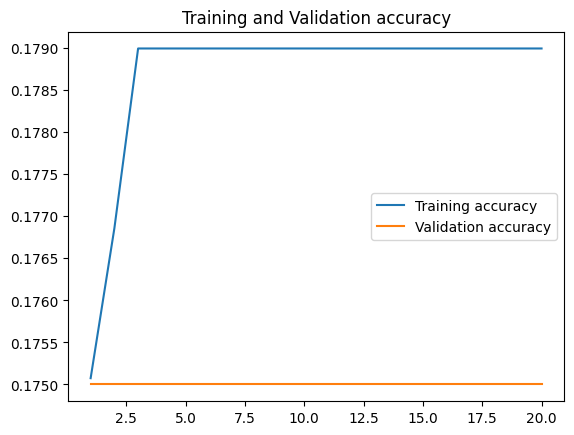

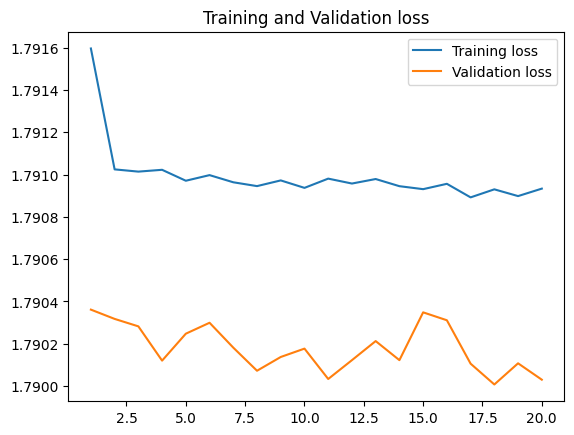

In [23]:
epochs = range(1, len(first_model_acc) + 1)

plt.plot(epochs, first_model_acc, label = 'Training accuracy')
plt.plot(epochs, first_model_val_acc, label = 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, first_model_loss, label = 'Training loss')
plt.plot(epochs, first_model_val_loss, label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step


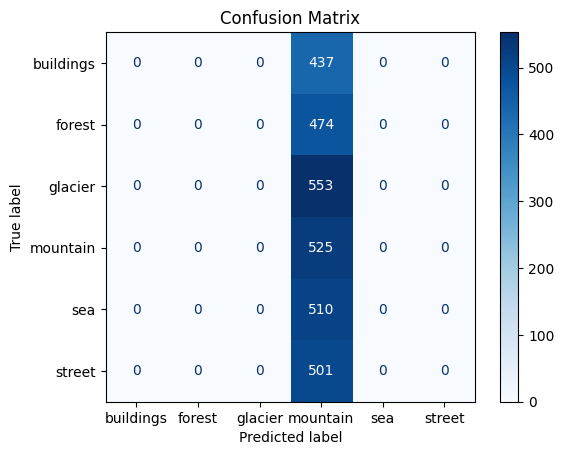

In [24]:
y_pred_probs = model.predict(test_dataset_final)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = test_dataset_final.classes

class_labels = list(test_dataset_final.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [49]:
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

for i, label in enumerate(class_labels):
    print(f"Class: {label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1-score:  {f1[i]:.4f}")
    print()

Class: buildings
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Class: forest
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Class: glacier
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Class: mountain
  Precision: 0.1750
  Recall:    1.0000
  F1-score:  0.2979

Class: sea
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Class: street
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000



# Model Enhanced

In [25]:
import keras_tuner as kt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
def my_model(hp):

    WEIGHT_DECAY = hp.Choice('weight_decay', [1e-2, 1e-3, 1e-4])
    DROPOUT_RATE = hp.Choice('dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5])

    inputs = keras.Input(shape = (150, 150, 3))
    x = data_augmentation(inputs)

    x = layers.Conv2D(
        filters = hp.Choice('conv1_filters', [32, 64, 128]),
        kernel_size = 3,
        padding = 'same',
        kernel_regularizer = regularizers.l2(WEIGHT_DECAY),
    )(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(
        filters = hp.Choice('conv2_filters', [64, 128, 256]),
        kernel_size = 3,
        padding = 'same',
        kernel_regularizer = regularizers.l2(WEIGHT_DECAY),
    )(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(
        filters = hp.Choice('conv3_filters', [128, 256, 512]),
        kernel_size = 3,
        padding = 'same',
        kernel_regularizer = regularizers.l2(WEIGHT_DECAY),
    )(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(
        filters = hp.Choice('conv4_filters', [256, 512, 1024]),
        kernel_size = 3,
        padding = 'same',
        kernel_regularizer = regularizers.l2(WEIGHT_DECAY),
    )(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)

    x = layers.Dense(units = hp.Choice('dense1_units', [256, 512, 1028]),
        kernel_regularizer = regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.Dropout(DROPOUT_RATE)(x)

    x = layers.Dense(units = hp.Choice('dense2_units', [256, 512, 1028]),
        kernel_regularizer = regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.Dropout(DROPOUT_RATE)(x)

    outputs = layers.Dense(6, activation = 'softmax')(x)

    model = keras.Model(inputs = inputs, outputs = outputs)

    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model

# Callbacks

In [27]:
lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 2,
    min_lr = 1e-6,
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True

)

# Hyperparameters Tuning

In [28]:
# tuner = kt.Hyperband(
#     my_model,
#     objective = 'val_accuracy',
#     max_epochs = 20,
#     factor = 3,
#     directory = 'tuner_dir',
#     project_name = 'cnn_tuning'
# )

# tuner.search(
#     train_dataset_final,
#     validation_data = test_dataset_final,
#     callbacks = [lr_scheduler, earlystop]
# )

# best_hp = tuner.get_best_hyperparameters(1)[0]
# print("Best HPs:", best_hp.values)

In [29]:
# Best hyperparam
best_hp = {'weight_decay': 0.001, 'dropout_rate': 0.3, 'conv1_filters': 64, 'conv2_filters': 64, 'conv3_filters': 512, 'conv4_filters': 512, 'dense1_units': 1028, 'dense2_units': 1028, 'learning_rate': 0.0001, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}
best_hp

{'weight_decay': 0.001,
 'dropout_rate': 0.3,
 'conv1_filters': 64,
 'conv2_filters': 64,
 'conv3_filters': 512,
 'conv4_filters': 512,
 'dense1_units': 1028,
 'dense2_units': 1028,
 'learning_rate': 0.0001,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0013'}

In [30]:
def my_model(WEIGHT_DECAY, DROPOUT_RATE, CONV_FILTER, DENSE_UNITS, LEARNING_RATE):

    inputs = keras.Input(shape = (150, 150, 3))
    x = data_augmentation(inputs)

    x = layers.Conv2D(
        filters = CONV_FILTER[0],
        kernel_size = 3,
        padding = 'same',
        kernel_regularizer = regularizers.l2(WEIGHT_DECAY),
    )(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(
        filters = CONV_FILTER[1],
        kernel_size = 3,
        padding = 'same',
        kernel_regularizer = regularizers.l2(WEIGHT_DECAY),
    )(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(
        filters = CONV_FILTER[2],
        kernel_size = 3,
        padding = 'same',
        kernel_regularizer = regularizers.l2(WEIGHT_DECAY),
    )(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(
        filters = CONV_FILTER[3],
        kernel_size = 3,
        padding = 'same',
        kernel_regularizer = regularizers.l2(WEIGHT_DECAY),
    )(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)

    x = layers.Dense(units = DENSE_UNITS[0],
        kernel_regularizer = regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.Dropout(DROPOUT_RATE)(x)

    x = layers.Dense(units = DENSE_UNITS[1],
        kernel_regularizer = regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.Dropout(DROPOUT_RATE)(x)

    outputs = layers.Dense(6, activation = 'softmax')(x)

    model = keras.Model(inputs = inputs, outputs = outputs)

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = LEARNING_RATE),
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model

In [31]:
model_enhenced = my_model(WEIGHT_DECAY = best_hp['weight_decay'],
                         DROPOUT_RATE = best_hp['dropout_rate'],
                         CONV_FILTER = [best_hp[k] for k in ['conv1_filters', 'conv2_filters', 'conv2_filters', 'conv3_filters']],
                         DENSE_UNITS = [best_hp[k] for k in ['dense1_units', 'dense2_units']],
                         LEARNING_RATE = best_hp['learning_rate'])

In [32]:
model_enhenced.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 150, 150, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 18, 18, 512)         │         295,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 18, 18, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 44,080,342 (168.15 MB)

 Trainable params: 44,074,822 (168.13 MB)

 Non-trainable params: 5,520 (21.56 KB)

In [33]:
history_enhanced = model_enhenced.fit(train_dataset_final, validation_data = test_dataset_final, epochs = 30, verbose = 2, callbacks = [lr_scheduler, earlystop])

Epoch 1/30
439/439 - 69s - 158ms/step - accuracy: 0.5106 - loss: 4.5065 - val_accuracy: 0.5450 - val_loss: 4.3029 - learning_rate: 1.0000e-04
Epoch 2/30
439/439 - 58s - 131ms/step - accuracy: 0.5704 - loss: 4.0483 - val_accuracy: 0.5250 - val_loss: 4.2553 - learning_rate: 1.0000e-04
Epoch 3/30
439/439 - 58s - 132ms/step - accuracy: 0.5975 - loss: 3.6416 - val_accuracy: 0.5250 - val_loss: 3.9523 - learning_rate: 1.0000e-04
Epoch 4/30
439/439 - 58s - 132ms/step - accuracy: 0.6179 - loss: 3.2663 - val_accuracy: 0.4710 - val_loss: 3.7929 - learning_rate: 1.0000e-04
Epoch 5/30
439/439 - 58s - 132ms/step - accuracy: 0.6325 - loss: 2.9470 - val_accuracy: 0.5907 - val_loss: 3.0164 - learning_rate: 1.0000e-04
Epoch 6/30
439/439 - 58s - 132ms/step - accuracy: 0.6396 - loss: 2.6635 - val_accuracy: 0.5940 - val_loss: 2.8265 - learning_rate: 1.0000e-04
Epoch 7/30
439/439 - 58s - 133ms/step - accuracy: 0.6521 - loss: 2.4326 - val_accuracy: 0.5853 - val_loss: 2.5925 - learning_rate: 1.0000e-04
Epoch 

In [34]:
model_enhenced.save('my_model.keras')

In [35]:
second_model_acc = history_enhanced.history['accuracy']
second_model_val_acc = history_enhanced.history['val_accuracy']
second_model_loss = history_enhanced.history['loss']
second_model_val_loss = history_enhanced.history['val_loss']

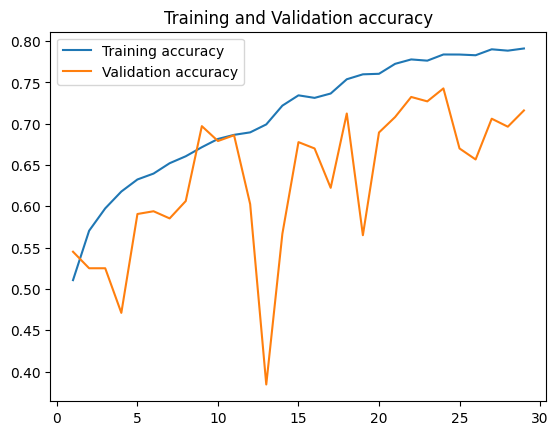

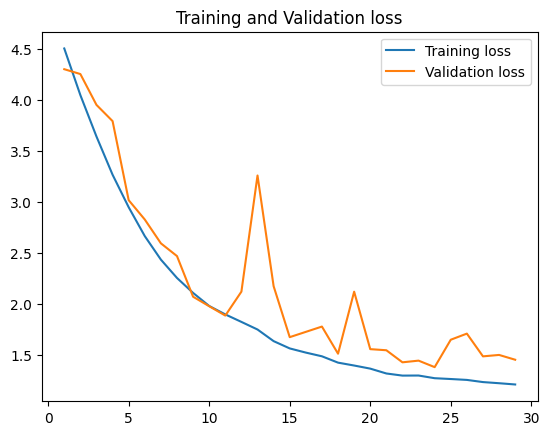

In [36]:
epochs = range(1, len(second_model_acc) + 1)

plt.plot(epochs, second_model_acc, label = 'Training accuracy')
plt.plot(epochs, second_model_val_acc, label = 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, second_model_loss, label = 'Training loss')
plt.plot(epochs, second_model_val_loss, label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step


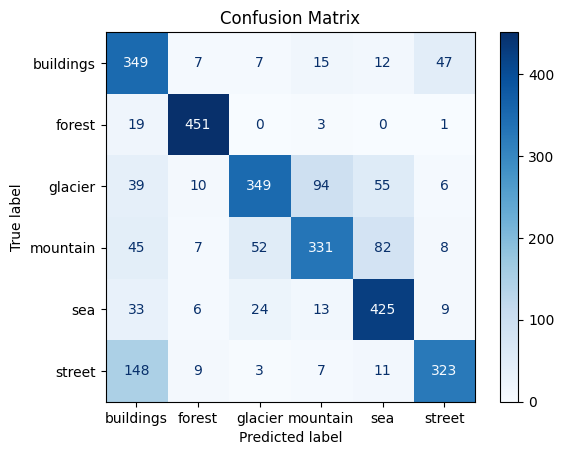

In [37]:
y_pred_probs_ = model_enhenced.predict(test_dataset_final)
y_pred_ = np.argmax(y_pred_probs_, axis=1)

y_true_ = test_dataset_final.classes

class_labels = list(test_dataset_final.class_indices.keys())

cm = confusion_matrix(y_true_, y_pred_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [50]:
precision, recall, f1, _ = precision_recall_fscore_support(y_true_, y_pred_, average=None)

for i, label in enumerate(class_labels):
    print(f"Class: {label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1-score:  {f1[i]:.4f}")
    print()

Class: buildings
  Precision: 0.5513
  Recall:    0.7986
  F1-score:  0.6523

Class: forest
  Precision: 0.9204
  Recall:    0.9515
  F1-score:  0.9357

Class: glacier
  Precision: 0.8023
  Recall:    0.6311
  F1-score:  0.7065

Class: mountain
  Precision: 0.7149
  Recall:    0.6305
  F1-score:  0.6700

Class: sea
  Precision: 0.7265
  Recall:    0.8333
  F1-score:  0.7763

Class: street
  Precision: 0.8198
  Recall:    0.6447
  F1-score:  0.7218



# EfficientNet

In [51]:
def mbcov_block(inputs, filters, kernel_size, strides, expansion_factor, se_ratio = 0.25, drop_rate = 0.0):
    input_channels = inputs.shape[-1]
    x = inputs

    expanded_channels = input_channels * expansion_factor
    if expansion_factor != 1:
        x = layers.Conv2D(expanded_channels, 1, padding = 'same', use_bias = False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('swish')(x)

    x = layers.DepthwiseConv2D(kernel_size, strides = strides, padding = 'same', use_bias = False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    if se_ratio :
        se = layers.GlobalAveragePooling2D()(x)
        se = layers.Reshape((1, 1, expanded_channels))(se)
        se = layers.Conv2D(int(expanded_channels * se_ratio), 1, activation = 'swish', padding = 'same')(se)
        se = layers.Conv2D(expanded_channels, 1, activation = 'sigmoid', padding = 'same')(se)
        x = layers.multiply([x, se])

    x = layers.Conv2D(filters, 1, padding = 'same', use_bias = False)(x)
    x = layers.BatchNormalization()(x)

    if strides == 1 and input_channels == filters:
        x = layers.Add()([inputs, x])

    return x

In [52]:
def efficientnet(input_shape = (150, 150, 3), num_classes = 6):
    inputs = keras.Input(shape = input_shape)
    x = data_augmentation(inputs)
    
    x = layers.Conv2D(32, 3, strides = 2, padding = 'same', use_bias = False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    x = mbcov_block(x, filters = 16, kernel_size = 3, strides = 1, expansion_factor = 1)

    for _ in range(2):
        x = mbcov_block(x, filters = 24, kernel_size = 3, strides = 1 if _ else 2, expansion_factor = 6)

    for _ in range(2):
        x = mbcov_block(x, filters = 40, kernel_size = 5, strides = 1 if _ else 2, expansion_factor = 6)

    for _ in range(3):
        x = mbcov_block(x, filters = 80, kernel_size = 3, strides = 1 if _ else 2, expansion_factor = 6)

    for _ in range(3):
        x = mbcov_block(x, filters = 112, kernel_size = 5, strides = 1, expansion_factor = 6)
    
    for _ in range(4):
        x = mbcov_block(x, filters = 192, kernel_size = 5, strides = 1 if _ else 2, expansion_factor = 6)
    
    x = mbcov_block(x, filters = 320, kernel_size = 3, strides = 1, expansion_factor = 6)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.models.Model(inputs, outputs)
    return model

In [56]:
EfficientNet = efficientnet()
EfficientNet.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 75, 75, 32)     │            864 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_54    │ (None, 75, 75, 32)     │            128 │ conv2d_72[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_32             │ (None, 75, 75, 32)     │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_16       │ (None, 75, 75, 32)     │            288 │ activation_32[0][0]    │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_55    │ (None, 75, 75, 32)     │            128 │ depthwise_conv2d_16[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_33             │ (None, 75, 75, 32)     │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ activation_33[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_16 (Reshape)      │ (None, 1, 1, 32)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_73 (Conv2D)        │ (None, 1, 1, 8)        │            264 │ reshape_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_74 (Conv2D)        │ (None, 1, 1, 32)       │            288 │ conv2d_73[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_16 (Multiply)    │ (None, 75, 75, 32)     │              0 │ activation_33[0][0],   │
│                           │                        │                │ conv2d_74[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_75 (Conv2D)        │ (None, 75, 75, 16)     │            512 │ multiply_16[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_56    │ (None, 75, 75, 16)     │             64 │ conv2d_75[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_76 (Conv2D)        │ (None, 75, 75, 96)     │          1,536 │ batch_normalization_5… │
├──────────────────────

 Total params: 6,772,070 (25.83 MB)

 Trainable params: 6,732,614 (25.68 MB)

 Non-trainable params: 39,456 (154.12 KB)

In [57]:
def custom_hinge_loss(y_true, y_pred, margin=1.0):

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    loss = tf.maximum(0.0, margin - y_true * y_pred)

    return tf.reduce_mean(loss)

In [58]:
EfficientNet.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate = 1e-3),
    loss = custom_hinge_loss,
    metrics = ['accuracy']
)

In [59]:
history_efficientnet = EfficientNet.fit(train_dataset_final, validation_data = test_dataset_final, epochs = 20, verbose = 2, callbacks = [lr_scheduler, earlystop])

Epoch 1/20


I0000 00:00:1748709587.480581     109 service.cc:148] XLA service 0x79be902a8be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748709587.483337     109 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748709587.483361     109 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
E0000 00:00:1748709597.232995     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748709597.369052     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748709598.026227     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

439/439 - 131s - 298ms/step - accuracy: 0.4602 - loss: 0.9237 - val_accuracy: 0.1700 - val_loss: 0.9705 - learning_rate: 0.0010
Epoch 2/20
439/439 - 35s - 79ms/step - accuracy: 0.5726 - loss: 0.9049 - val_accuracy: 0.5127 - val_loss: 0.9145 - learning_rate: 0.0010
Epoch 3/20
439/439 - 34s - 77ms/step - accuracy: 0.6185 - loss: 0.8971 - val_accuracy: 0.6393 - val_loss: 0.8933 - learning_rate: 0.0010
Epoch 4/20
439/439 - 34s - 77ms/step - accuracy: 0.6628 - loss: 0.8898 - val_accuracy: 0.4517 - val_loss: 0.9244 - learning_rate: 0.0010
Epoch 5/20
439/439 - 34s - 78ms/step - accuracy: 0.6930 - loss: 0.8845 - val_accuracy: 0.6523 - val_loss: 0.8913 - learning_rate: 0.0010
Epoch 6/20
439/439 - 34s - 77ms/step - accuracy: 0.7125 - loss: 0.8815 - val_accuracy: 0.6703 - val_loss: 0.8885 - learning_rate: 0.0010
Epoch 7/20
439/439 - 34s - 77ms/step - accuracy: 0.7304 - loss: 0.8785 - val_accuracy: 0.6217 - val_loss: 0.8964 - learning_rate: 0.0010
Epoch 8/20
439/439 - 34s - 77ms/step - accuracy: 0

In [60]:
eff_acc = history_efficientnet.history['accuracy']
eff_val_acc = history_efficientnet.history['val_accuracy']
eff_loss = history_efficientnet.history['loss']
eff_val_loss = history_efficientnet.history['val_loss']

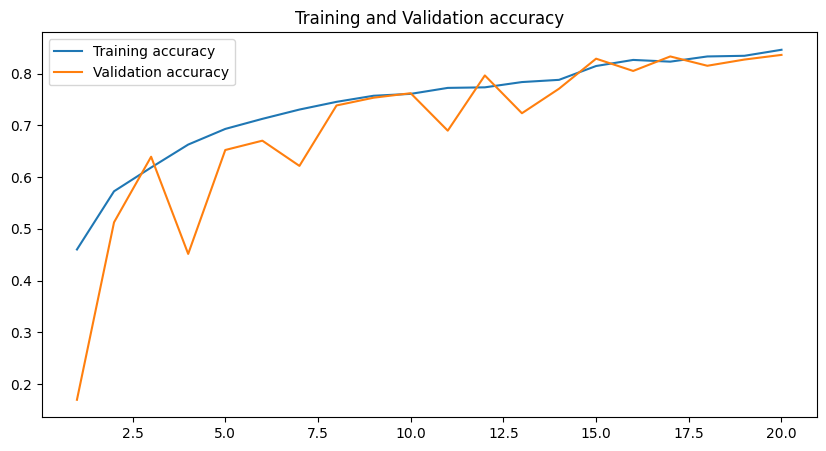

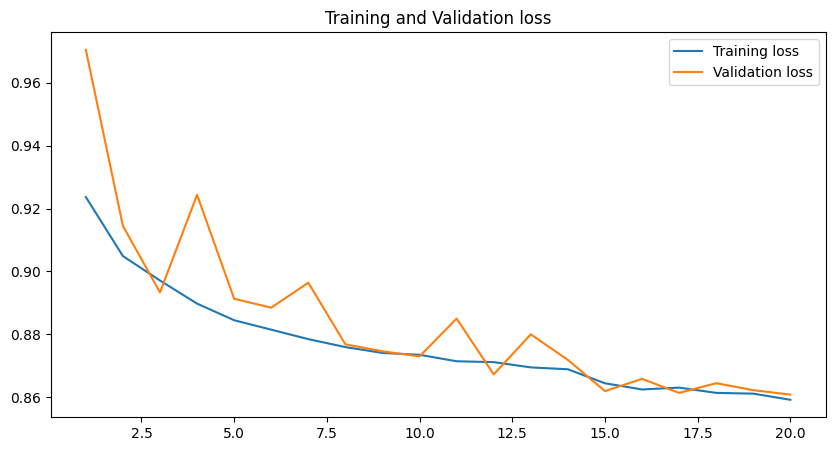

In [61]:
epochs = range(1, len(eff_acc) + 1)

plt.figure(figsize = (10, 5))

plt.plot(epochs, eff_acc, label = 'Training accuracy')
plt.plot(epochs, eff_val_acc, label = 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure(figsize = (10, 5))

plt.plot(epochs, eff_loss, label = 'Training loss')
plt.plot(epochs, eff_val_loss, label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step


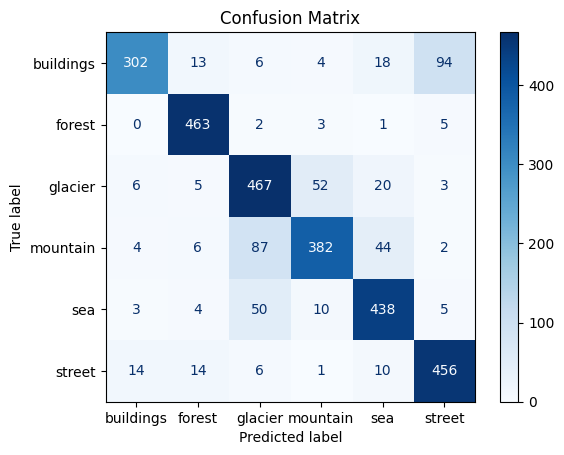

In [70]:
y_pred_probs_eff = EfficientNet.predict(test_dataset_final)
y_pred_eff = np.argmax(y_pred_probs_eff, axis=1)

y_true_eff = test_dataset_final.classes

class_labels = list(test_dataset_final.class_indices.keys())

cm = confusion_matrix(y_true_eff, y_pred_eff)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [71]:
precision, recall, f1, _ = precision_recall_fscore_support(y_true_eff, y_pred_eff, average=None)

for i, label in enumerate(class_labels):
    print(f"Class: {label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1-score:  {f1[i]:.4f}")
    print()

Class: buildings
  Precision: 0.9179
  Recall:    0.6911
  F1-score:  0.7885

Class: forest
  Precision: 0.9168
  Recall:    0.9768
  F1-score:  0.9459

Class: glacier
  Precision: 0.7557
  Recall:    0.8445
  F1-score:  0.7976

Class: mountain
  Precision: 0.8451
  Recall:    0.7276
  F1-score:  0.7820

Class: sea
  Precision: 0.8249
  Recall:    0.8588
  F1-score:  0.8415

Class: street
  Precision: 0.8071
  Recall:    0.9102
  F1-score:  0.8555



# Comparison

In [73]:
epochs20_second_model_acc = history_enhanced.history['accuracy'][:20]
epochs20_second_model_val_acc = history_enhanced.history['val_accuracy'][:20]
epochs20_second_model_loss = history_enhanced.history['loss'][:20]
epochs20_second_model_val_loss = history_enhanced.history['val_loss'][:20]

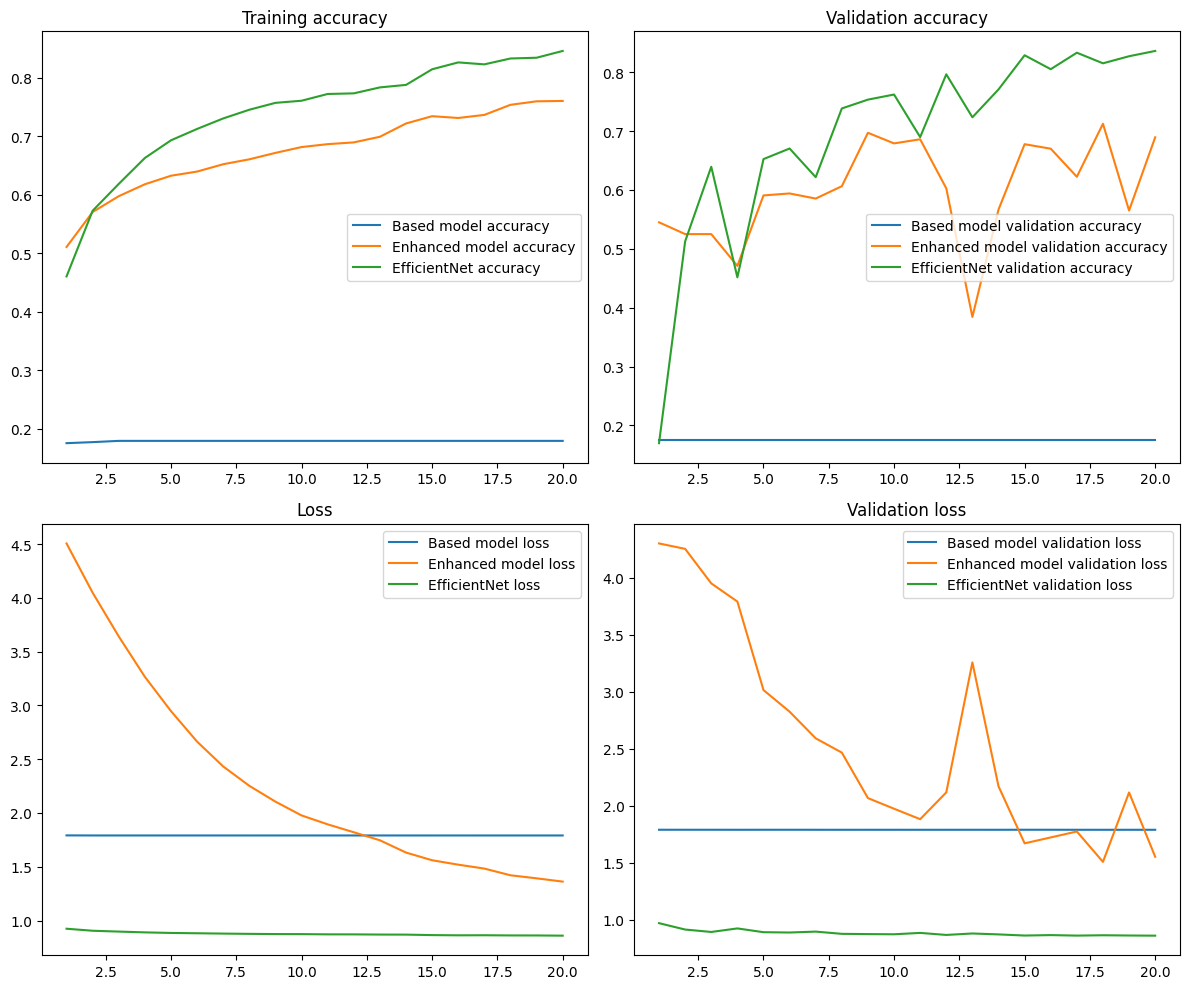

In [77]:
epochs = range(1, len(epochs20_second_model_acc) + 1)

fig, ax = plt.subplots(2, 2, figsize = (12, 10))

ax[0 ,0].plot(epochs, first_model_acc, label = 'Based model accuracy')
ax[0, 0].plot(epochs, epochs20_second_model_acc, label = 'Enhanced model accuracy')
ax[0, 0].plot(epochs, eff_acc, label = 'EfficientNet accuracy')
ax[0, 0].set_title('Training accuracy')
ax[0, 0].legend()

ax[0 ,1].plot(epochs, first_model_val_acc, label = 'Based model validation accuracy')
ax[0, 1].plot(epochs, epochs20_second_model_val_acc, label = 'Enhanced model validation accuracy')
ax[0, 1].plot(epochs, eff_val_acc, label = 'EfficientNet validation accuracy')
ax[0, 1].set_title('Validation accuracy')
ax[0, 1].legend()

ax[1, 0].plot(epochs, first_model_loss, label = 'Based model loss')
ax[1, 0].plot(epochs, epochs20_second_model_loss, label = 'Enhanced model loss')
ax[1, 0].plot(epochs, eff_loss, label = 'EfficientNet loss')
ax[1, 0].set_title('Loss')
ax[1, 0].legend()

ax[1, 1].plot(epochs, first_model_val_loss, label = 'Based model validation loss')
ax[1, 1].plot(epochs, epochs20_second_model_val_loss, label = 'Enhanced model validation loss')
ax[1, 1].plot(epochs, eff_val_loss, label = 'EfficientNet validation loss')
ax[1, 1].set_title('Validation loss')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

# Accuracy

In [78]:
print(f'Accuracy of based model: {accuracy_score(y_true, y_pred)}')
print(f'Accuracy of enhanced model: {accuracy_score(y_true_, y_pred_)}')
print(f'Accuracy of EfficientNet: {accuracy_score(y_true_eff, y_pred_eff)}')

Accuracy of based model: 0.175
Accuracy of enhanced model: 0.7426666666666667
Accuracy of EfficientNet: 0.836


# Precision

In [80]:
print(f"Precision of based model: {precision_score(y_true, y_pred, average='weighted')}")
print(f"Precision of enhanced model: {precision_score(y_true_, y_pred_, average='weighted')}")
print(f"Precision of EfficientNet: {precision_score(y_true_eff, y_pred_eff, average='weighted')}")

Precision of based model: 0.030625
Precision of enhanced model: 0.7591455371029673
Precision of EfficientNet: 0.8407721439939954


# F1

In [81]:
print(f"F1 Score of based model: {f1_score(y_true, y_pred, average='weighted')}")
print(f"F1 Score of enhanced model: {f1_score(y_true_, y_pred_, average='weighted')}")
print(f"F1 Score of EfficientNet: {f1_score(y_true_eff, y_pred_eff, average='weighted')}")

F1 Score of based model: 0.052127659574468084
F1 Score of enhanced model: 0.7428483485238371
F1 Score of EfficientNet: 0.8341086995936623


# Recall

In [82]:
print(f"Recall of based model: {recall_score(y_true, y_pred, average='weighted')}")
print(f"Recall of enhanced model: {recall_score(y_true_, y_pred_, average='weighted')}")
print(f"Recall of EfficientNet: {recall_score(y_true_eff, y_pred_eff, average='weighted')}")

Recall of based model: 0.175
Recall of enhanced model: 0.7426666666666667
Recall of EfficientNet: 0.836
